# Datos de Urgencias en México - 2023

## Manuel Andrés Cota Santeliz

Primero, importamos las librerias necesarias.

In [13]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import math
import zipfile
import shutil
import os
import requests
import matplotlib.pyplot as plt
import calendar

Ahora, descargamos los datos de la Secretaría de Salud.

In [2]:
# Liga a los datos par descargar.
csv_urgencias_url = "http://www.dgis.salud.gob.mx/descargas/datosabiertos/urgencias/Urgencias_2023.zip?v=2024.05.06"

# Si ya exsite un directorio de datos, lo eliminamos para obtener los datos desde cero.
if os.path.exists("./data"):
  shutil.rmtree("./data")
os.mkdir("./data")

# Preparamos la funcion para descargar los datos.
def download_url(url, save_path, chunk_size=128):
  # Hacemos la llamada y almacenamos la respuesta.
  r = requests.get(url, stream=True)
  # Calculamos el tamaño total de la respuesta para usarlo en la barra de progreso.
  total = int(r.headers.get('content-length', 0))
  # Preparamos la barra de progreso.
  with tqdm(total=total, unit="B", unit_scale=True, position=0, leave=True, desc="DOWNLOADING DATA") as bar:
    # Abrimos un nuevo archivo para guardar la descarga.
    with open(save_path, 'wb') as fd:
      for chunk in tqdm(r.iter_content(chunk_size=chunk_size)):
        bar.update(len(chunk))
        fd.write(chunk)

# Llamamos a la función de descarga, almacenando el archivo comprimido como raw_data.
download_url(csv_urgencias_url, "./data/raw_data")

# Descomprimimos el archivo.
with zipfile.ZipFile("./data/raw_data", 'r') as zip_ref:
    zip_ref.extractall("./data")


DOWNLOADING DATA:   0%|          | 0.00/230M [00:00<?, ?B/s]

0it [00:00, ?it/s]

Ahora, generamos los dataframes a partir de cada archivo TSV que tenemos.

NOTAS:
 - El proceso puede ser tardado, considerando que son muchos datos.
 - Solo estamos generando df_urgencias. Si se quieren los demas, habra que
descomentar las instrucciones en el código.

In [16]:
# Preparamos la liga al archivo en nuestro directorio.
urgencias_path = "./data/Registros/Urgencias.txt"
# afecciones_path = "./data/Registros/Afecciones.txt"
# medicamentos_path = "./data/Registros/Medicamentos.txt"
# procedimientos_path = "./data/Registros/Procedimientos.txt"

# Calculamos el mayor divisor posible para la cantidad de registros.
# Nos es util para el tamaño de chunks.
def get_divisor(n) :
    i = n - 1
    while True:
        if (n % i==0) :
            return i
        i = i - 1
# Función para generar el DataFrame.
def get_dataframe(desc, path):
  # Obtenemos el total de registros que tendremos.
  with open(path, 'r') as fp:
    lines = len(fp.readlines())
    update_cycle = get_divisor(lines)

  # Generamos el DataFrame.
  df = []
  with tqdm(total=lines, desc="Generating " + desc) as bar:
    for chunk in pd.read_csv(path,chunksize=update_cycle,comment='#',sep='|',engine='python'):
        df.append(chunk)
        bar.update(chunk.shape[0])
  df = pd.concat(df,ignore_index=True)

  # Devolvemos el DataFrame generado.
  return df

# Generamos el DataFrame para Urgencias.
df_urgencias = get_dataframe("df_urgencias", "./data/Registros/Urgencias.txt")
# df_afecciones = get_dataframe("df_afecciones", "./data/Registros/Afecciones.txt")
# df_medicamentos = get_dataframe("df_medicamentos", "./data/Registros/Medicamentos.txt")
# df_procedimientos = get_dataframe("df_procedimientos", "./data/Registros/Procedimientos.txt")


Generating df_urgencias:   0%|          | 0/7806626 [00:00<?, ?it/s]

Analizando el dataframe, vemos que contamos con 22 atributos para cada registro de urgencias.

In [17]:
# Analizamos el DataFrame.
df_urgencias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7806625 entries, 0 to 7806624
Data columns (total 23 columns):
 #   Column           Dtype  
---  ------           -----  
 0   ID               int64  
 1   CLUES            object 
 2   fechaalta        object 
 3   EDAD             int64  
 4   CVEEDAD          int64  
 5   SEXO             int64  
 6   ENTRESIDENCIA    int64  
 7   MUNRESIDENCIA    int64  
 8   DERHAB           object 
 9   TIPOURGENCIA     int64  
 10  MOTATE           int64  
 11  TIPOCAMA         int64  
 12  ENVIADOA         int64  
 13  MP               int64  
 14  AFECPRIN         object 
 15  IRA              int64  
 16  PLANEDA          object 
 17  SOBRESEDA        float64
 18  fechaingreso     object 
 19  HORASESTANCIA    object 
 20  MES_ESTADISTICO  int64  
 21  hora_ingreso     object 
 22  hora_alta        object 
dtypes: float64(1), int64(13), object(9)
memory usage: 1.3+ GB


Creamos un nuevo indice usando la fecha de ingreso convertida a tipo de fecha.

In [18]:
df_urgencias = df_urgencias.set_index(pd.to_datetime(df_urgencias['fechaingreso']))

df_urgencias.head()


,ID,CLUES,fechaalta,EDAD,CVEEDAD,SEXO,ENTRESIDENCIA,MUNRESIDENCIA,DERHAB,TIPOURGENCIA,...,MP,AFECPRIN,IRA,PLANEDA,SOBRESEDA,fechaingreso,HORASESTANCIA,MES_ESTADISTICO,hora_ingreso,hora_alta
fechaingreso,,,,,,,,,,,,,,,,,,,,,
2023-01-03,1,MCSSA004791,2023-01-03,5,5,1,15,92,1,2,...,8,J00X,8,8,NaN,2023-01-03,000:10,1,14:40,14:50
2023-01-09,2,MCSSA002872,2023-01-09,17,5,2,15,42,1,2,...,8,Z349,8,8,NaN,2023-01-09,000:15,1,17:00,17:15
2023-01-09,3,MCSSA001636,2023-01-09,29,5,1,15,104,1,1,...,8,D649,8,8,NaN,2023-01-09,000:12,1,23:13,23:25
2023-01-10,4,MCSSA002184,2023-01-10,23,5,2,15,109,1,2,...,8,R51X,8,8,NaN,2023-01-10,001:27,1,04:43,06:10
2023-01-11,5,MCSSA007673,2023-01-11,19,5,2,15,18,1,2,...,8,O009,8,8,NaN,2023-01-11,000:26,1,10:04,10:30


Aunque los datos ya son solo del 2023, nos aseguramos filtrando a partir del 01/01/2023.
Además, filtramos también a solo los registros en Sonora (ENTRESIDENCIA = 26)

In [19]:
df_urgencias = df_urgencias[(df_urgencias['fechaingreso'] > '2023-01-01') & (df_urgencias["ENTRESIDENCIA"] == 26)]

df_urgencias


,ID,CLUES,fechaalta,EDAD,CVEEDAD,SEXO,ENTRESIDENCIA,MUNRESIDENCIA,DERHAB,TIPOURGENCIA,...,MP,AFECPRIN,IRA,PLANEDA,SOBRESEDA,fechaingreso,HORASESTANCIA,MES_ESTADISTICO,hora_ingreso,hora_alta
fechaingreso,,,,,,,,,,,,,,,,,,,,,
2023-07-12,21959,ZSSSA000695,2023-07-12,46,5,2,26,29,13,2,...,8,R739,8,8,NaN,2023-07-12,000:20,7,13:00,13:20
2023-07-17,42035,ZSSSA001506,2023-07-17,53,5,2,26,30,0,2,...,8,I209,8,8,NaN,2023-07-17,001:00,7,21:14,22:14
2023-08-06,53041,ZSSSA012853,2023-08-06,6,5,2,26,55,1,1,...,8,T141,8,8,NaN,2023-08-06,001:56,8,17:41,19:37
2023-08-14,76455,SPSSA002770,2023-08-14,62,5,2,26,30,2,1,...,8,K800,8,8,NaN,2023-08-14,001:19,8,15:56,17:15
2023-01-20,120250,ZSSSA012853,2023-01-20,2,5,1,26,17,1,1,...,8,J219,1,8,NaN,2023-01-20,001:14,1,14:38,15:52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-19,7603470,PLSSA000612,2023-04-19,47,5,2,26,30,0,1,...,8,T009,8,8,NaN,2023-04-19,004:00,4,16:00,20:00
2023-04-19,7610756,PLSSA000612,2023-04-19,54,5,1,26,30,0,1,...,8,T009,8,8,NaN,2023-04-19,004:30,4,16:00,20:30
2023-04-13,7614076,PLSSA003663,2023-04-13,56,5,2,26,17,13,2,...,8,R040,8,8,NaN,2023-04-13,000:20,4,08:50,09:10


Como podemos ver, varios atributos de los datos tienen nombres algo rebuscados,
como por ejemplo "ENTRESIDENCIA", "MOTATE" o "DERHAB".

In [20]:
df_urgencias.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 192854 entries, 2023-07-12 to 2023-09-09
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ID               192854 non-null  int64  
 1   CLUES            192854 non-null  object 
 2   fechaalta        192854 non-null  object 
 3   EDAD             192854 non-null  int64  
 4   CVEEDAD          192854 non-null  int64  
 5   SEXO             192854 non-null  int64  
 6   ENTRESIDENCIA    192854 non-null  int64  
 7   MUNRESIDENCIA    192854 non-null  int64  
 8   DERHAB           192854 non-null  object 
 9   TIPOURGENCIA     192854 non-null  int64  
 10  MOTATE           192854 non-null  int64  
 11  TIPOCAMA         192854 non-null  int64  
 12  ENVIADOA         192854 non-null  int64  
 13  MP               192854 non-null  int64  
 14  AFECPRIN         192854 non-null  object 
 15  IRA              192854 non-null  int64  
 16  PLANEDA          19285

 Por lo tanto, comenzamos cambiando el nombre de algunas columnas a algo más entendible.

In [21]:
df_urgencias = df_urgencias.rename(columns={
  "ENTRESIDENCIA": "Estado",
  "MUNRESIDENCIA": "Municipio",
  "DERHAB": "Derechohabiencia",
  "MOTATE": "MotivoAtencion",
  "AFECPRIN": "AfeccionPrincipal",
})

df_urgencias.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 192854 entries, 2023-07-12 to 2023-09-09
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ID                 192854 non-null  int64  
 1   CLUES              192854 non-null  object 
 2   fechaalta          192854 non-null  object 
 3   EDAD               192854 non-null  int64  
 4   CVEEDAD            192854 non-null  int64  
 5   SEXO               192854 non-null  int64  
 6   Estado             192854 non-null  int64  
 7   Municipio          192854 non-null  int64  
 8   Derechohabiencia   192854 non-null  object 
 9   TIPOURGENCIA       192854 non-null  int64  
 10  MotivoAtencion     192854 non-null  int64  
 11  TIPOCAMA           192854 non-null  int64  
 12  ENVIADOA           192854 non-null  int64  
 13  MP                 192854 non-null  int64  
 14  AfeccionPrincipal  192854 non-null  object 
 15  IRA                192854 non-null 

Comencemos analizando cuantos registros hubo por municipio.

In [22]:
mun_counts = df_urgencias[["Municipio", "ID"]].groupby("Municipio").count()
mun_counts = mun_counts.drop([998, 999])

mun_counts

,ID
Municipio,
1,161
2,6858
3,2460
4,579
5,21
...,...
68,36
69,85
70,145


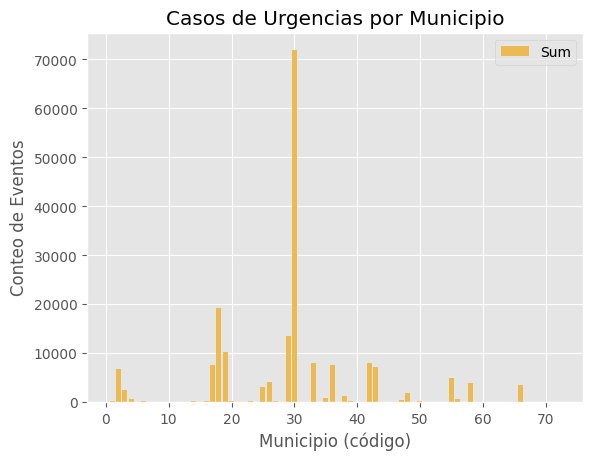

In [23]:
with plt.style.context(('ggplot')):
  plt.bar(mun_counts.index, mun_counts.ID, color = "#ECBA53", label = "Sum")
  plt.xlabel("Municipio (código)")
  plt.ylabel("Conteo de Eventos")
  plt.title("Casos de Urgencias por Municipio")
  plt.legend(fontsize = 10)
  plt.show()

Podemos notar que la gran mayoría de los casos de urgencias ocurren en el municipio
con código 30. En la referncia de los códigos por municipio (los cuales estan
ordenados alfabeticamente) vemos que se trata de Hermosillo.

Si se contara con los datos de tamaño de población por municipio, podríamos ver
si, en proporción, esto es normal o si el numero es considerablemente grande, aun
para el municipio con mayor tamaño de población.

Podemos también revisar la ocurrencia de los eventos a lo largo del tiempo.


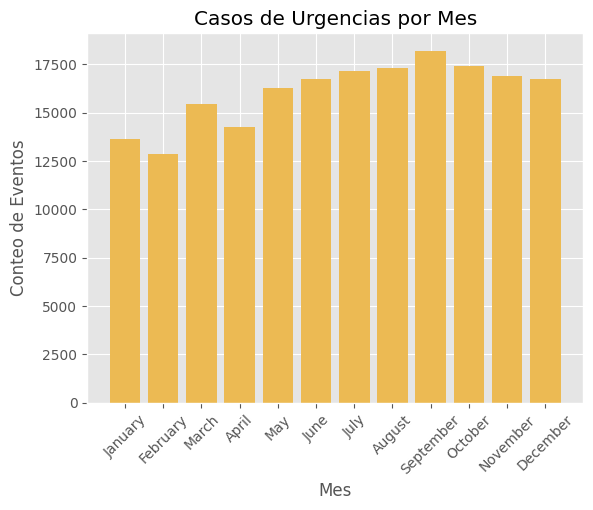

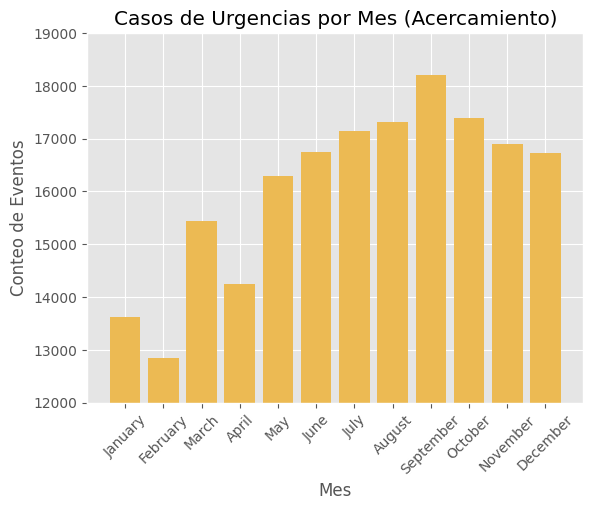

In [24]:
ingresos_al_mes = df_urgencias[["fechaingreso", "ID"]].groupby(by=[df_urgencias.index.month]).count()
ingresos_al_mes

with plt.style.context(('ggplot')):
  plt.bar([ calendar.month_name[i+1] for i in range(12)], ingresos_al_mes.ID, color = "#ECBA53")
  plt.xlabel("Mes")
  plt.ylabel("Conteo de Eventos")
  plt.xticks(rotation=45)
  plt.title("Casos de Urgencias por Mes")
  plt.show()

with plt.style.context(('ggplot')):
  plt.bar([ calendar.month_name[i+1] for i in range(12)], ingresos_al_mes.ID, color = "#ECBA53")
  plt.xlabel("Mes")
  plt.ylabel("Conteo de Eventos")
  plt.ylim(12000, 19000)
  plt.xticks(rotation=45)
  plt.title("Casos de Urgencias por Mes (Acercamiento)")
  plt.show()


Se puede observar un maximo notable de ingresos a urgencias en el mes de septiembre.
Además, podemos ver el minimo de eventos durante el mes de febrero. Sin embargo, viendo
la gráfica sin acercamiento, podemos ver que la diferencia no es en realidad tan marcada.

Podemos también ver si hay una diferncia notable en la cantidad de casos de urgencia
en distintos sexos.

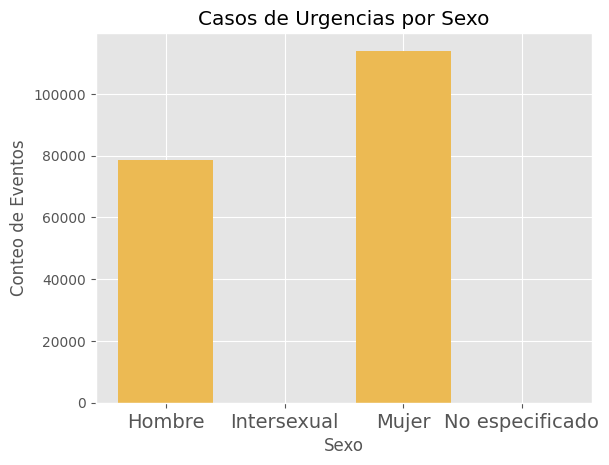

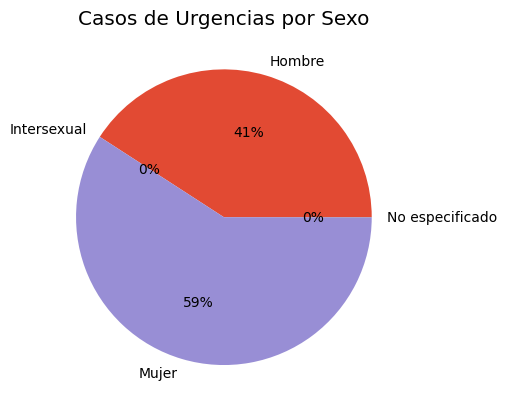

In [38]:
# Actualizamos los valores conla etiqueta correcta.
df_urgencias["SEXO"] = df_urgencias["SEXO"].replace(0, "No especificado")
df_urgencias["SEXO"] = df_urgencias["SEXO"].replace(1, "Hombre")
df_urgencias["SEXO"] = df_urgencias["SEXO"].replace(2, "Mujer")
df_urgencias["SEXO"] = df_urgencias["SEXO"].replace(3, "Intersexual")
df_urgencias["SEXO"] = df_urgencias["SEXO"].replace(9, "Se ignora")

# Generamos el conteo.
sex_counts = df_urgencias[["SEXO", "ID"]].groupby("SEXO").count()
total_count = len(df_urgencias[["SEXO", "ID"]])

# Graficamos el conteo.
with plt.style.context(('ggplot')):
  plt.bar(sex_counts.index, sex_counts.ID, color = "#ECBA53")
  plt.xlabel("Sexo")
  plt.ylabel("Conteo de Eventos")
  plt.xticks([0, 1, 2, 3], fontsize=14)
  plt.title("Casos de Urgencias por Sexo")
  plt.show()
with plt.style.context(('ggplot')):
  plt.pie(sex_counts.ID, labels=sex_counts.index, autopct=lambda p: '{:.0f}%'.format(p))
  plt.title("Casos de Urgencias por Sexo")
  plt.show()

Desgraciadamente hay pocos datos para "No especificado" e "Intersexual", y de hecho nada de datos para "Se ignora". Por lo tanto podemos solo graficar "Hombre" y "Mujer" y ver los datos de manera más clara.

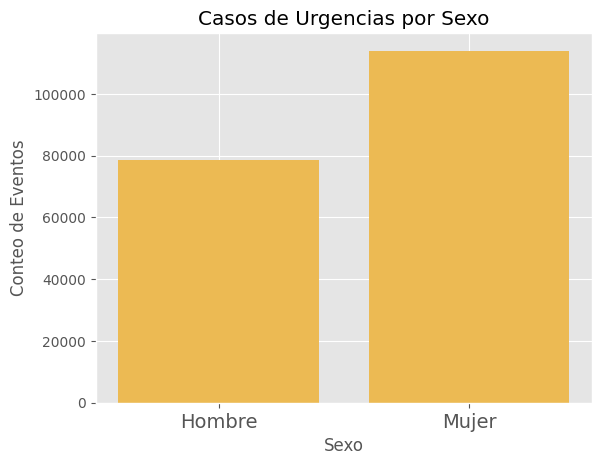

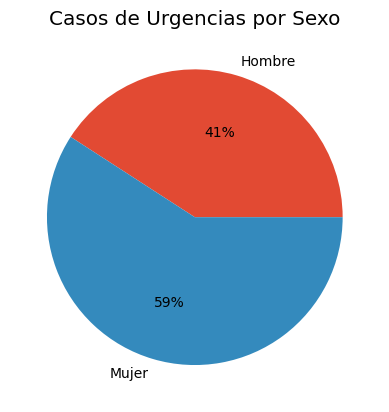

In [42]:
# Generamos el conteo.
sex_counts = sex_counts[sex_counts["ID"] > 100]
total_count = sex_counts["ID"].sum()

# Graficamos el conteo.
with plt.style.context(('ggplot')):
  plt.bar(sex_counts.index, sex_counts.ID, color = "#ECBA53")
  plt.xlabel("Sexo")
  plt.ylabel("Conteo de Eventos")
  plt.xticks([0, 1], fontsize=14)
  plt.title("Casos de Urgencias por Sexo")
  plt.show()
with plt.style.context(('ggplot')):
  plt.pie(sex_counts.ID, labels=sex_counts.index, autopct=lambda p: '{:.0f}%'.format(p))
  plt.title("Casos de Urgencias por Sexo")
  plt.show()

Parece ser que hubo notablemente mas casos de urgencias de Mujeres que de cualquier
otro sexo.

Enfocandonos en casos de mujeres, veamos si algo sobresale analizando los motivos de atencion por los cuales fueron ingresadas.

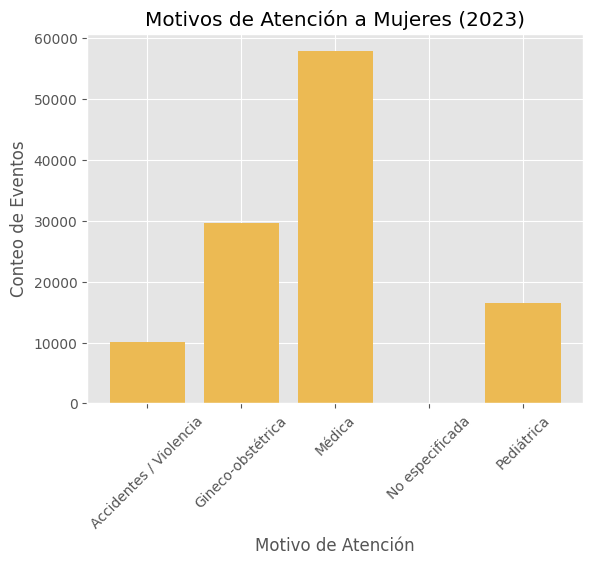

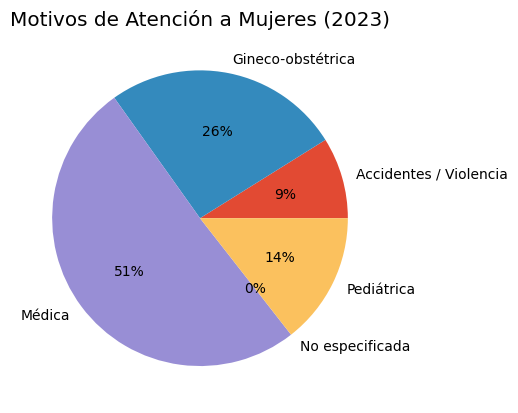

In [45]:
df_urgencias["MotivoAtencion"] = df_urgencias["MotivoAtencion"].replace(1, "Accidentes / Violencia")
df_urgencias["MotivoAtencion"] = df_urgencias["MotivoAtencion"].replace(2, "Médica")
df_urgencias["MotivoAtencion"] = df_urgencias["MotivoAtencion"].replace(3, "Gineco-obstétrica")
df_urgencias["MotivoAtencion"] = df_urgencias["MotivoAtencion"].replace(4, "Pediátrica")
df_urgencias["MotivoAtencion"] = df_urgencias["MotivoAtencion"].replace(9, "No especificada")

mujeres = df_urgencias[df_urgencias["SEXO"] == "Mujer"][["MotivoAtencion", "ID"]].groupby("MotivoAtencion").count()

with plt.style.context(('ggplot')):
  plt.bar(mujeres.index, mujeres.ID, color = "#ECBA53")
  plt.xlabel("Motivo de Atención")
  plt.ylabel("Conteo de Eventos")
  plt.xticks(fontsize=10, rotation=45)
  plt.title("Motivos de Atención a Mujeres (2023)")
  plt.show()

with plt.style.context(('ggplot')):
  plt.pie(mujeres.ID, labels=mujeres.index, autopct=lambda p: '{:.0f}%'.format(p))
  plt.title("Motivos de Atención a Mujeres (2023)")
  plt.show()


Hubo muchos más ingresos por motivos médicos que por accidentes o de cualquier otro tipo.

Veamos si para los hombres es un caso similar.

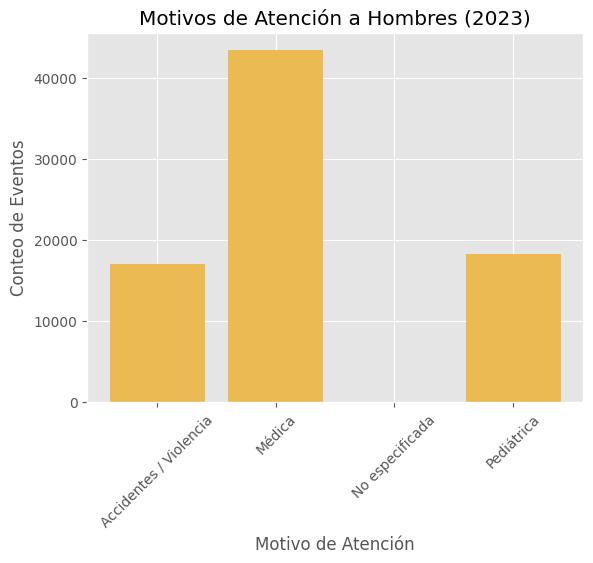

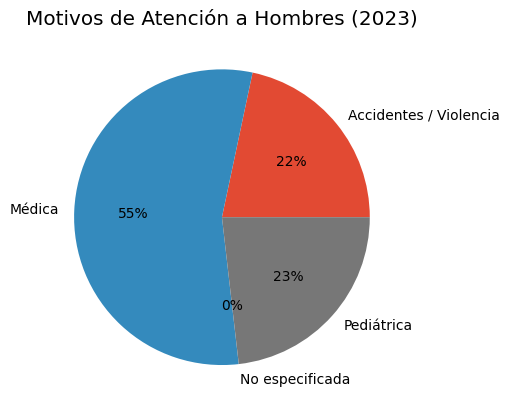

In [47]:
hombres = df_urgencias[df_urgencias["SEXO"] == "Hombre"][["MotivoAtencion", "ID"]].groupby("MotivoAtencion").count()

with plt.style.context(('ggplot')):
  plt.bar(hombres.index, hombres.ID, color = "#ECBA53")
  plt.xlabel("Motivo de Atención")
  plt.ylabel("Conteo de Eventos")
  plt.xticks(fontsize=10, rotation=45)
  plt.title("Motivos de Atención a Hombres (2023)")
  plt.show()

with plt.style.context(('ggplot')):
  plt.pie(hombres.ID, labels=hombres.index, autopct=lambda p: '{:.0f}%'.format(p))
  plt.title("Motivos de Atención a Hombres (2023)")
  plt.show()

Podemos ver que aquí también se da una mayor cantidad de casos de urgencias por motivos médicos, y que la razón menos común es también por accidentes o violencia.

# Conclusión

Al ver los datos podemos concluir que, en el año 2023, hubo un pico de casos de urgencias durante el mes de septiembre, mientras que el mes con menor cantidad de ingresos a urgencias fue febrero.

Se observa también un mayor numero de ingresos a urgencias de mujeres que de cualquier otro sexo. En general, invariablemente del sexo, podemos ver que los principales motivos de ingresos a urgencias son médicos, mientras que los accidentes, envenenamiento y violencia son el motivo menos común de ingreso a urgencias.